## Seattle-Tacoma-Bellevue

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller

In [2]:
def check_for_stationarity(X):
    # H_0 in adfuller is unit root exists (non-stationary)
    # p-value must be less then 0.01 for the series to be stationary with 99% confidence
    pvalue = adfuller(X)[1]
    return pvalue

In [3]:
# load data and convert date
df = pd.read_csv("./data/Seattle-Tacoma-Bellevue.csv")
df['DATE'] = pd.to_datetime(df['DATE'])

In [4]:
# validate dateset and create train test split
clean_df = pd.DataFrame(data=pd.date_range('1990-01-01', '2023-05-01', freq='MS'), columns=['ds'])
clean_df = clean_df.set_index('ds').join(df.set_index(['DATE']))
clean_df[clean_df['SMU53426604200000001'].isna()]
clean_df = clean_df.reset_index()
clean_df = clean_df.rename(columns={'SMU53426604200000001': 'y'})

train_df = clean_df.iloc[:round(clean_df.shape[0] * 0.9),]
test_df = clean_df.iloc[round(clean_df.shape[0] * 0.9):, ]

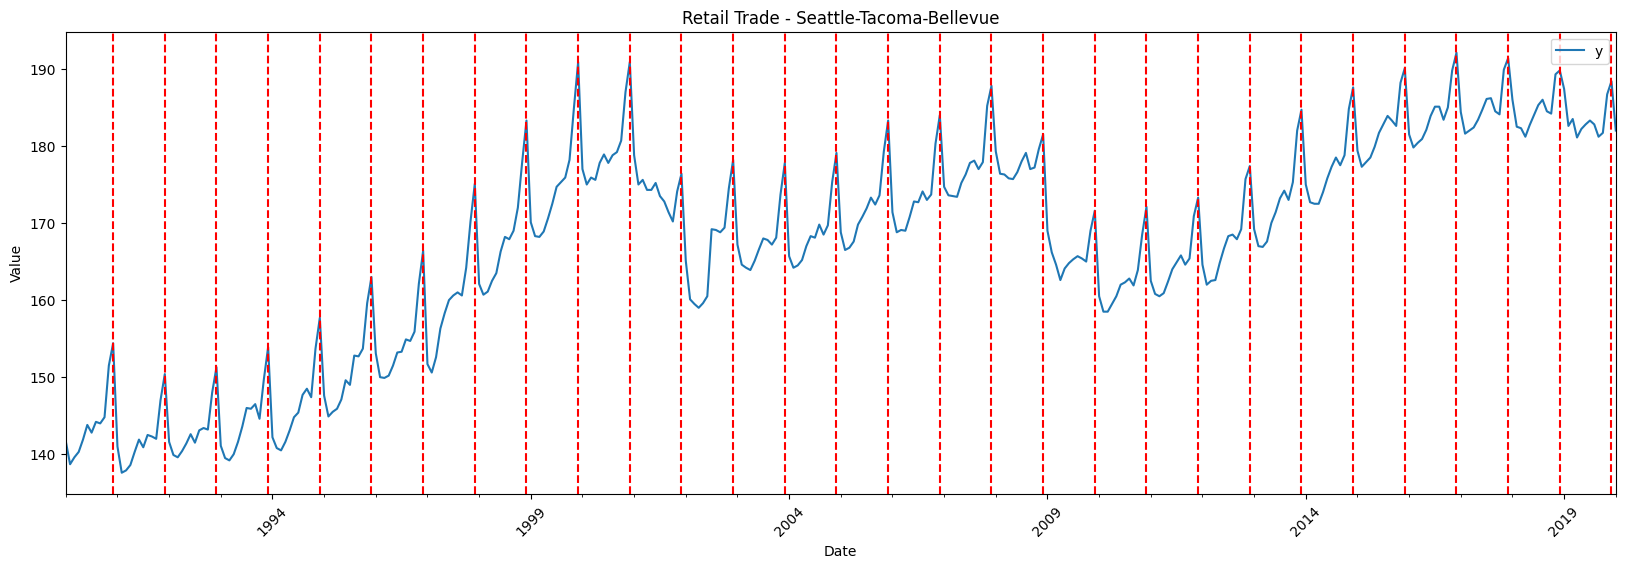

In [5]:
# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))
train_df.plot(x='ds', y='y', ax=ax)


# Add vertical lines at every 12th month
for i in range(1, len(train_df) // 12 + 1):
    twelfth_month = train_df.iloc[i * 12 - 1]['ds']
    ax.axvline(x=twelfth_month, color='r', linestyle='--')
    
# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Retail Trade - Seattle-Tacoma-Bellevue')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Save the plot
plt.savefig('images/seasonality.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [6]:
train_df['first_difference'] = train_df['y'].diff(periods=1)  
train_df['second_difference'] = train_df['first_difference'].diff(periods=1) 

C:\Users\monac\AppData\Local\Temp\ipykernel_17624\446402799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['first_difference'] = train_df['y'].diff(periods=1)
C:\Users\monac\AppData\Local\Temp\ipykernel_17624\446402799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['second_difference'] = train_df['first_difference'].diff(periods=1)


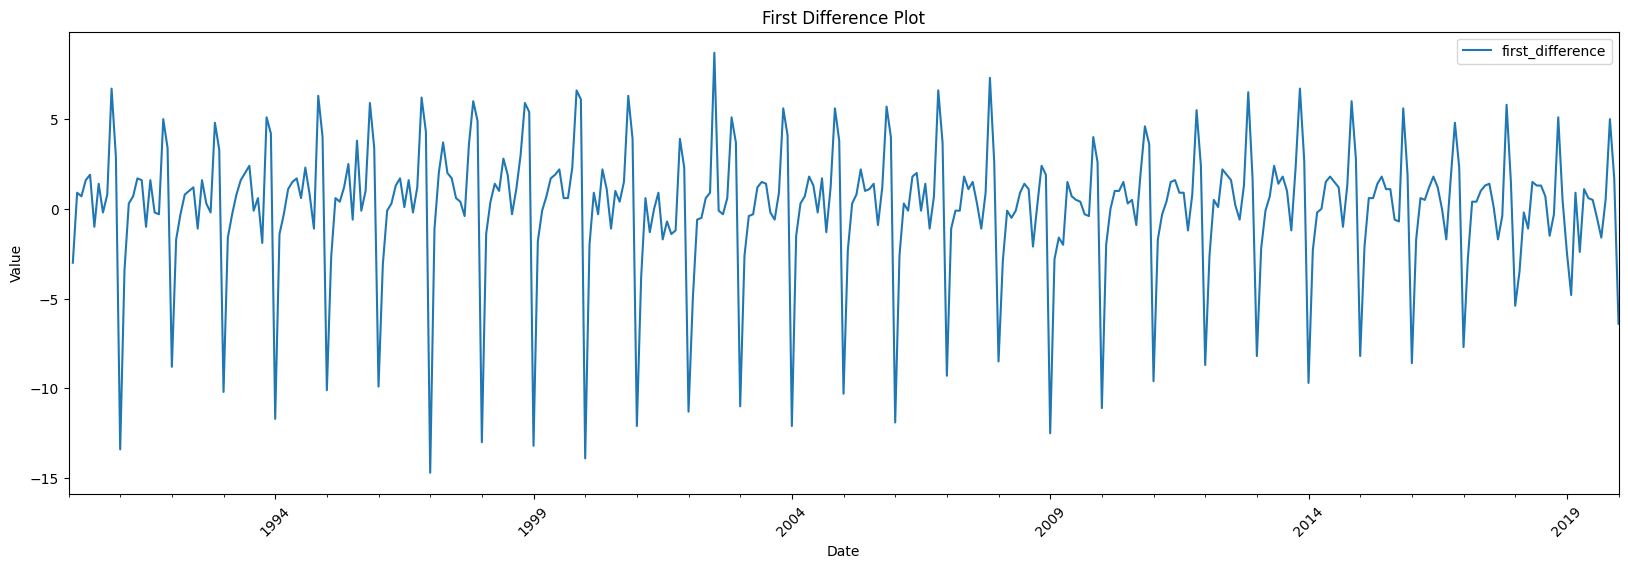

In [7]:
# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))
train_df.plot(x='ds', y='first_difference', ax=ax)

    
# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('First Difference Plot')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Save the plot
plt.savefig('images/sarima.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [8]:
pvalue = check_for_stationarity(train_df.first_difference.dropna().values)
print(pvalue)

0.03330612424248056


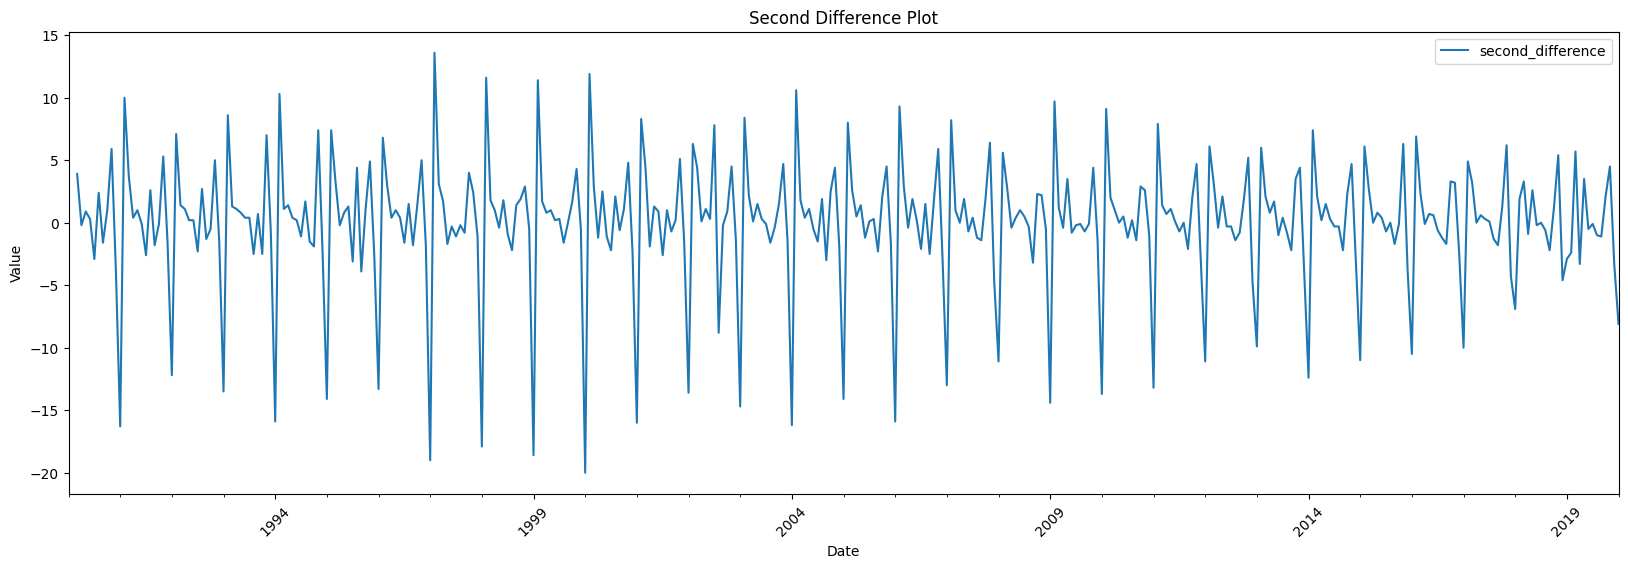

In [9]:
# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))
train_df.plot(x='ds', y='second_difference', ax=ax)

    
# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Second Difference Plot')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Save the plot
plt.savefig('images/stationarity.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [10]:
pvalue = check_for_stationarity(train_df.second_difference.dropna().values)
print(pvalue)

8.05667295409828e-19


In [11]:
# Calculate the PACF and ACF
nlags = 12
X_acf, X_acf_confs = sm.tsa.stattools.acf(train_df.second_difference.dropna().values, nlags=nlags, alpha=0.05)
X_pacf, X_pacf_confs = sm.tsa.stattools.pacf(train_df.second_difference.dropna().values, nlags=nlags, alpha=0.05)

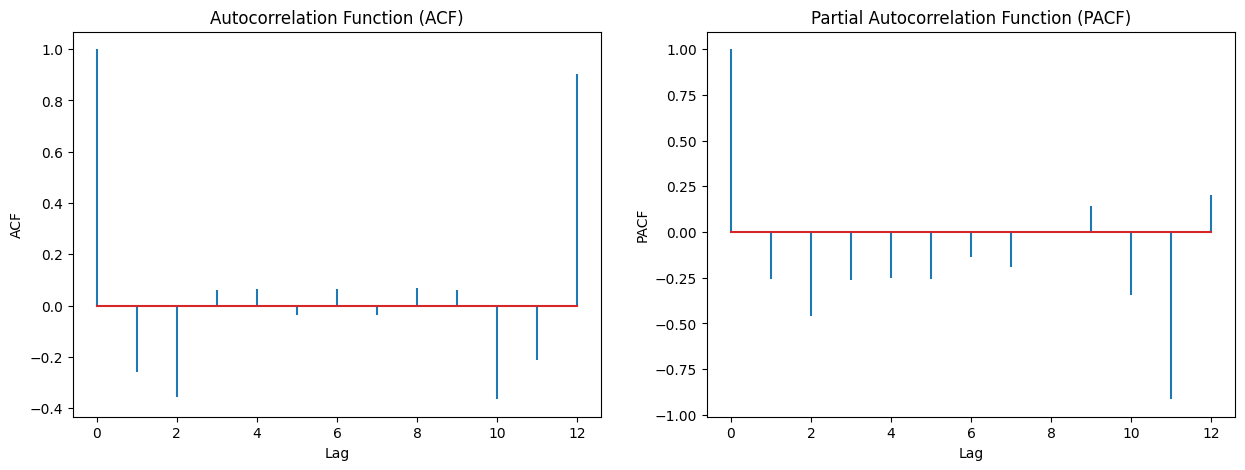

In [12]:
# Create subplot figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Plot ACF on the left subplot
ax1.stem(range(len(X_acf)), X_acf, markerfmt=' ')
ax1.set_xlabel('Lag')
ax1.set_ylabel('ACF')
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the right subplot
ax2.stem(range(len(X_pacf)), X_pacf, markerfmt=' ')
ax2.set_xlabel('Lag')
ax2.set_ylabel('PACF')
ax2.set_title('Partial Autocorrelation Function (PACF)') 

# Saving the figure in the images folder
fig.savefig('images/acf_pacf_plots.png')
plt.show() 

In [13]:
p = 11
d = 2
q = 0
P = 0
D = 0
Q = 1
S = 12
# Define the ARIMA model
# model = sm.tsa.ARIMA(train_df['y'], order=(p, d, q))
model = sm.tsa.SARIMAX(train_df['y'], order=(p, d, q), seasonal_order=(P, D, Q, S))
# model.arparams = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, coeff_ar_12]
# model.pacfparams = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, coeff_ar_12]
# Fit the model to the data
result = model.fit(maxiter=1000, method='powell')

Optimization terminated successfully.
         Current function value: 1.608512
         Iterations: 10
         Function evaluations: 1432


In [14]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  361
Model:             SARIMAX(11, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -580.673
Date:                               Tue, 25 Jul 2023   AIC                           1187.345
Time:                                       22:04:00   BIC                           1237.829
Sample:                                            0   HQIC                          1207.421
                                               - 361                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9966      0.006   -174.532      0.000      -1.008      -0.985
ar.L2         -0.9962      0.008   -125.219      0.000      -1.012      -0.981
ar.L3         -0.9911      0.009   -107.058      0.000      -1.009      -0.973
ar.L4         -0.9940      0.012    -83.814      0.000      -1.017      -0.971
ar.L5         -0.9945      0.014    -70.778      0.000      -1.022      -0.967
ar.L6         -0.9933      0.012    -80.303      0.000      -1.018      -0.969
ar.L7         -0.9918      0.012    -86.136      0.000      -1.014      -0.969
ar.L8         -0.9874      0.010   -101.600      0.000      -1.006      -0.968
ar.L9         -0.9910      0.007   -138.474      0.000      -1.005      -0.977
ar.L10        -0.9940      0.006   -180.149      0.000      -1.005      -0.983
ar.L11        -0.9931      0.004   -261.066      0.000      -1.001      -0.986
ma.S.L12      -0.6816      0.034    -19.996      0.000      -0.748      -0.615
sigma2         1.3580      0.057     23.856      0.000       1.246       1.470
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              1777.70
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             1.04
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
test_df['yhat'] = result.get_forecast(steps=test_df.shape[0]).predicted_mean

C:\Users\monac\AppData\Local\Temp\ipykernel_17624\3626989016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['yhat'] = result.get_forecast(steps=test_df.shape[0]).predicted_mean


In [16]:
test_df['APE'] = np.abs((test_df['yhat'] - test_df['y'])/test_df['y'])

C:\Users\monac\AppData\Local\Temp\ipykernel_17624\1411330854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['APE'] = np.abs((test_df['yhat'] - test_df['y'])/test_df['y'])


In [17]:
test_df['APE'].mean()*100

2.6188643142987003

In [18]:
# Store results for LateX document
summary_str = result.summary().tables[1].as_latex_tabular()
with open('summary.txt', 'w') as file:
    file.write(summary_str)

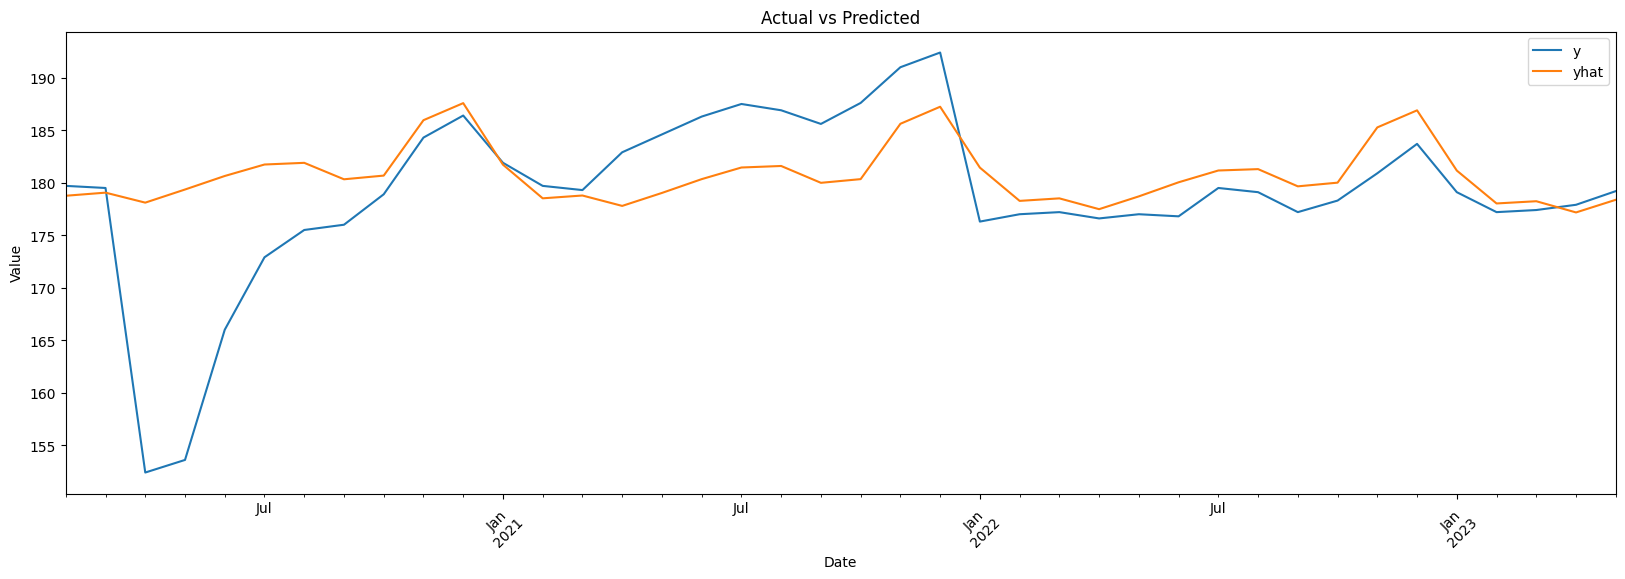

In [19]:
# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))
test_df.plot(x='ds', y='y', ax=ax)
test_df.plot(x='ds', y='yhat', ax=ax)
# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Actual vs Predicted')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Save the plot
plt.savefig('images/seattle_prediction.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Dallas-Fort Worth-Arlington

In [20]:
# load data and convert date
df = pd.read_csv('./data/Dallas-Fort-Worth-Arlington.csv')
df['DATE'] = pd.to_datetime(df['DATE'])

In [21]:
# validate dateset and create train test split
clean_df = pd.DataFrame(data=pd.date_range('1990-01-01', '2023-05-01', freq='MS'), columns=['ds'])
clean_df = clean_df.set_index('ds').join(df.set_index(['DATE']))
clean_df[clean_df['SMU48191004200000001'].isna()]
clean_df = clean_df.reset_index()
clean_df = clean_df.rename(columns={'SMU48191004200000001': 'y'})

train_df = clean_df.iloc[:round(clean_df.shape[0] * 0.9),]
test_df = clean_df.iloc[round(clean_df.shape[0] * 0.9):, ]

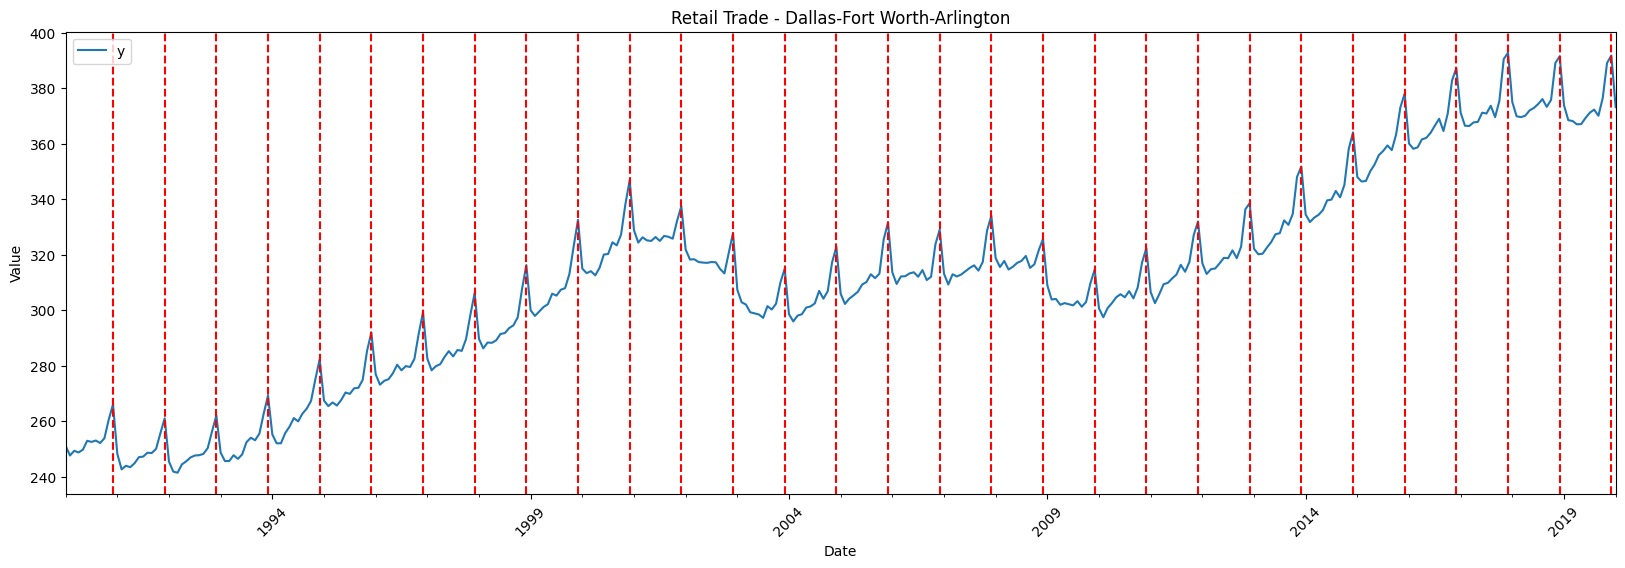

In [22]:
# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))
train_df.plot(x='ds', y='y', ax=ax)


# Add vertical lines at every 12th month
for i in range(1, len(train_df) // 12 + 1):
    twelfth_month = train_df.iloc[i * 12 - 1]['ds']
    ax.axvline(x=twelfth_month, color='r', linestyle='--')
    
# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Retail Trade - Dallas-Fort Worth-Arlington')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [23]:
train_df['first_difference'] = train_df['y'].diff(periods=1)  
train_df['second_difference'] = train_df['first_difference'].diff(periods=1) 

C:\Users\monac\AppData\Local\Temp\ipykernel_17624\446402799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['first_difference'] = train_df['y'].diff(periods=1)
C:\Users\monac\AppData\Local\Temp\ipykernel_17624\446402799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['second_difference'] = train_df['first_difference'].diff(periods=1)


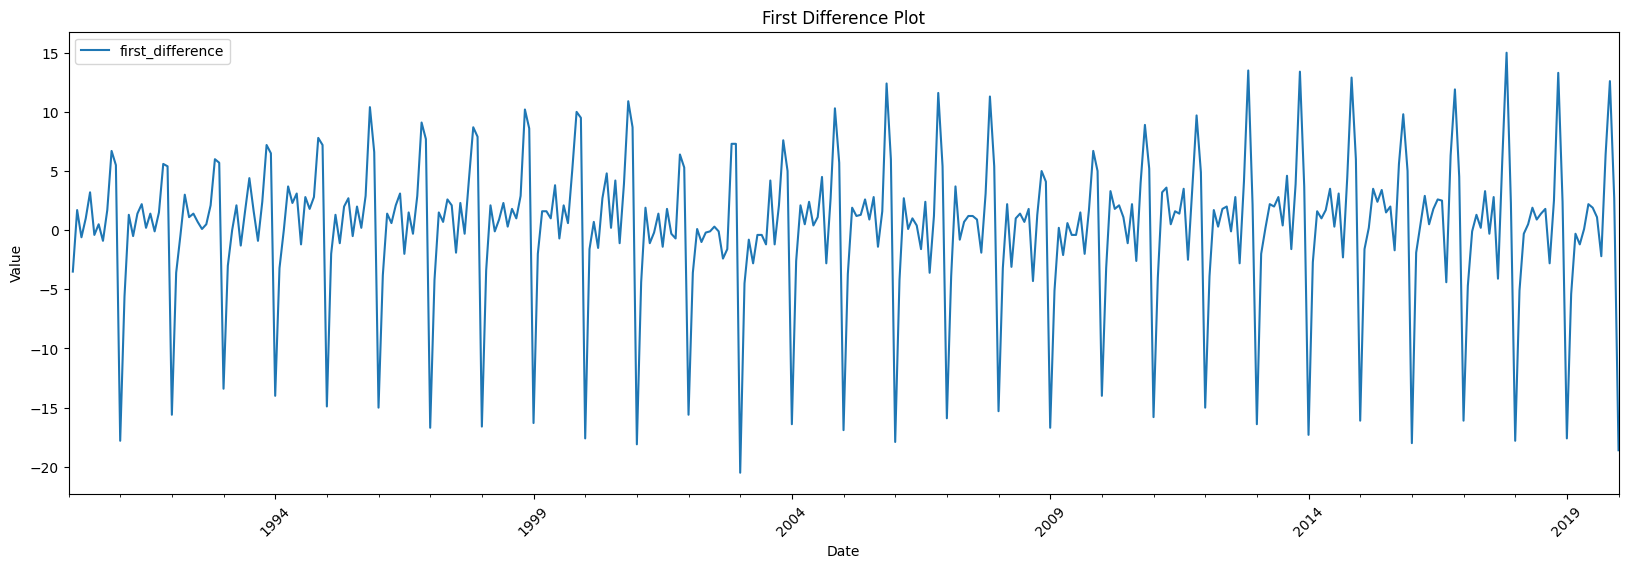

In [24]:
# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))
train_df.plot(x='ds', y='first_difference', ax=ax)

    
# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('First Difference Plot')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [25]:
pvalue = check_for_stationarity(train_df.first_difference.dropna().values)
print(pvalue)

0.0035433867827756095


In [26]:
# Calculate the PACF and ACF
nlags = 12
X_acf, X_acf_confs = sm.tsa.stattools.acf(train_df.second_difference.dropna().values, nlags=nlags, alpha=0.05)
X_pacf, X_pacf_confs = sm.tsa.stattools.pacf(train_df.second_difference.dropna().values, nlags=nlags, alpha=0.05)

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

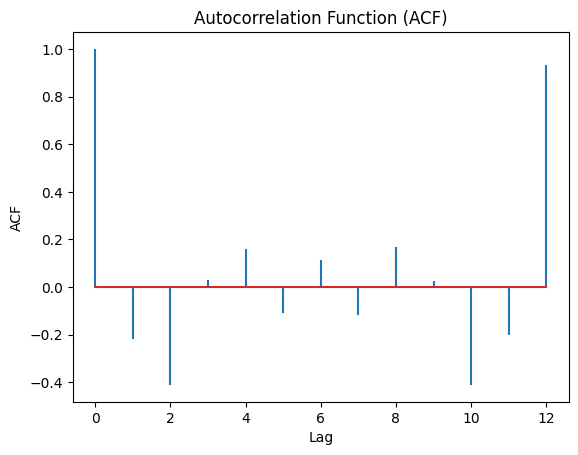

In [27]:
plt.stem(range(len(X_acf)), X_acf, markerfmt=' ')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF)')

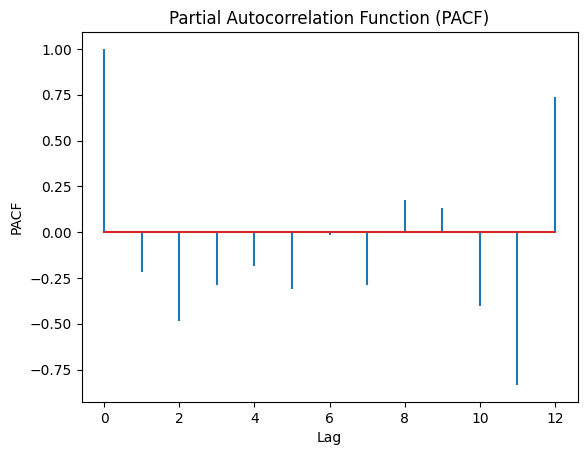

In [28]:
# plt.subplot(1, 2, 1)
plt.stem(range(len(X_pacf)), X_pacf, markerfmt=' ')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')

In [29]:
p = 0
d = 1
q = 0
P = 1
D = 1
Q = 1
S = 12
# Define the ARIMA model
# model = sm.tsa.ARIMA(train_df['y'], order=(p, d, q))
model = sm.tsa.SARIMAX(train_df['y'], order=(p, d, q), seasonal_order=(P, D, Q, S))
# model.arparams = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, coeff_ar_12]
# model.pacfparams = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, coeff_ar_12]
# Fit the model to the data
result = model.fit(maxiter=1000, method='powell')

Optimization terminated successfully.
         Current function value: 1.736598
         Iterations: 6
         Function evaluations: 205


In [30]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  361
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -626.912
Date:                              Tue, 25 Jul 2023   AIC                           1259.824
Time:                                      22:05:31   BIC                           1271.380
Sample:                                           0   HQIC                          1264.425
                                              - 361                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3291      0.074      4.462      0.000       0.185       0.474
ma.S.L12      -0.8229      0.049    -16.877      0.000      -0.918      -0.727
sigma2         2.1094      0.148     14.229      0.000       1.819       2.400
===================================================================================
Ljung-Box (L1) (Q):                   3.99   Jarque-Bera (JB):                 7.51
Prob(Q):                              0.05   Prob(JB):                         0.02
Heteroskedasticity (H):               1.11   Skew:                            -0.22
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Store results for LateX document
summary_str = result.summary().tables[1].as_latex_tabular()
with open('summary.txt', 'w') as file:
    file.write(summary_str)

In [31]:
test_df['yhat'] = result.get_forecast(steps=test_df.shape[0]).predicted_mean

C:\Users\monac\AppData\Local\Temp\ipykernel_17624\3626989016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['yhat'] = result.get_forecast(steps=test_df.shape[0]).predicted_mean


In [32]:
test_df['APE'] = np.abs((test_df['yhat'] - test_df['y'])/test_df['y'])

C:\Users\monac\AppData\Local\Temp\ipykernel_17624\1411330854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['APE'] = np.abs((test_df['yhat'] - test_df['y'])/test_df['y'])


In [33]:
test_df['APE'].mean()*100

1.8242914853500984

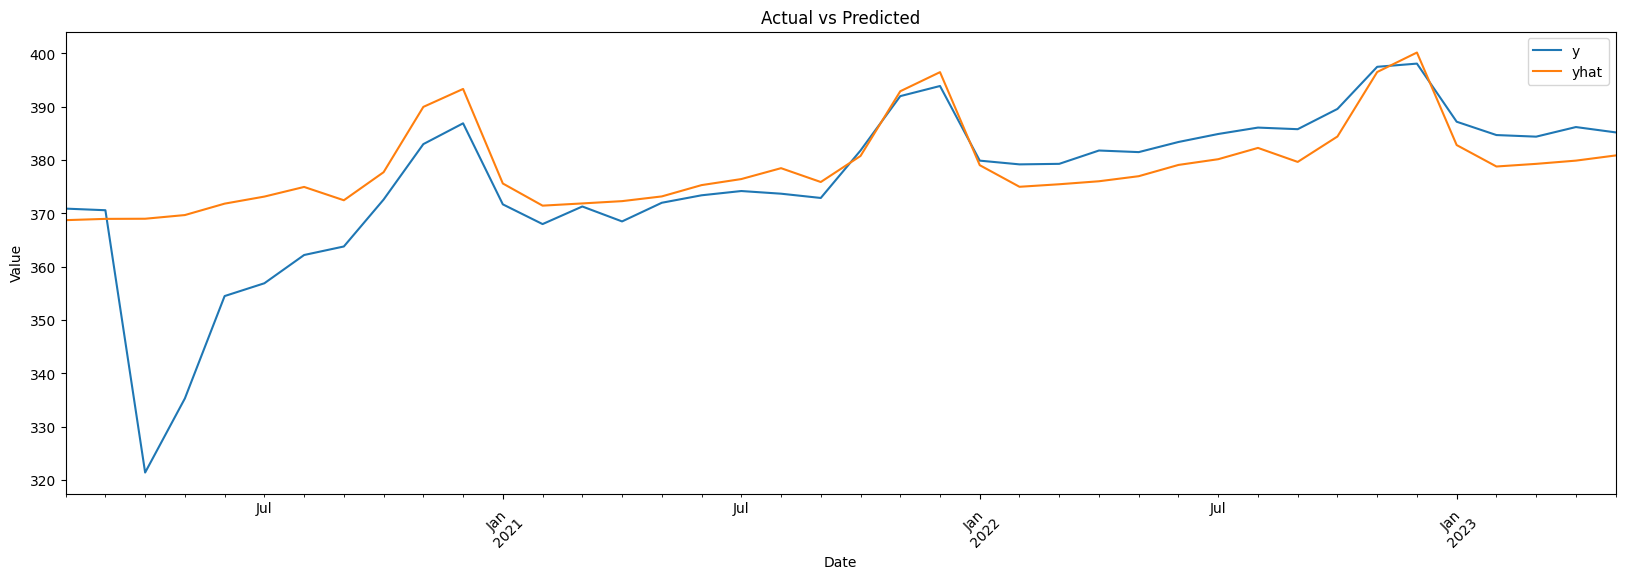

In [34]:
# Create the plot
fig, ax = plt.subplots(figsize=(20, 6))
test_df.plot(x='ds', y='y', ax=ax)
test_df.plot(x='ds', y='yhat', ax=ax)
# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Actual vs Predicted')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Save the plot
plt.savefig('images/dallas_prediction.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()